In [ ]:
本章介绍如何使用 TensorFlow 快速搭建动态模型。

模型的构建： tf.keras.Model 和 tf.keras.layers

模型的损失函数： tf.keras.losses

模型的优化器： tf.keras.optimizer

模型的评估： tf.keras.metrics



## 模型和层 model & layer

在TensorFlow中，推荐使用tf.keras 构建模型

keras 有两个重要概念：
模型和层

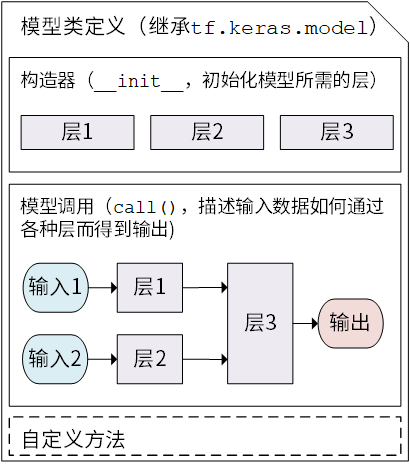

层将各种计算流程和变量进行了封装（例如基本的全连接层，CNN 的卷积层、池化层等）;

而模型则将各种层进行组织和连接，并封装成一个整体，描述了如何将输入数据通过各种层以及运算而得到输出。


In [ ]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super().__init__()     # Python 2 下使用 super(MyModel, self).__init__()
        # 此处添加初始化代码（包含 call 方法中会用到的层），例如
        # layer1 = tf.keras.layers.BuiltInLayer(...)
        # layer2 = MyCustomLayer(...)

    def call(self, input):
        # 此处添加模型调用的代码（处理输入并返回输出），例如
        # x = layer1(input)
        # output = layer2(x)
        return output

    # 还可以添加自定义的方法

- 对于上一章的简单线性模型，y_pred=a*X+b ,可以通过模型类的方式编写如下：

>注意，最大的区别是
这里，我们没有显式地声明 a 和 b 两个变量并写出 y_pred = a * X + b 这一线性变换，
而是建立了一个继承了 tf.keras.Model 的模型类 Linear 。
这个类在初始化部分实例化了一个 全连接层 （ tf.keras.layers.Dense ），并在 call 方法中对这个层进行调用，实现了线性变换的计算。

In [2]:
import tensorflow as tf

X = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
y = tf.constant([[10.0], [20.0]])


class Linear(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.dense = tf.keras.layers.Dense(
            units=1,  # 输出张量的维度
            activation=None,  # 激活函数
            kernel_initializer=tf.zeros_initializer(),  # 变量，对应于a
            bias_initializer=tf.zeros_initializer()   # 变量, 偏置向量，对应于b
        )

    def call(self, input):
        output = self.dense(input)
        return output


# 以下代码结构与前节类似
model = Linear()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
for i in range(100):
    with tf.GradientTape() as tape:
        y_pred = model(X)      # 调用模型 y_pred = model(X) 而不是显式写出 y_pred = a * X + b
        loss = tf.reduce_mean(tf.square(y_pred - y))
    grads = tape.gradient(loss, model.variables)    # 使用 model.variables 这一属性直接获得模型中的所有变量
    optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))
print(model.variables)

[<tf.Variable 'linear_1/dense_1/kernel:0' shape=(3, 1) dtype=float32, numpy=
array([[0.40784496],
       [1.191065  ],
       [1.9742855 ]], dtype=float32)>, <tf.Variable 'linear_1/dense_1/bias:0' shape=(1,) dtype=float32, numpy=array([0.78322077], dtype=float32)>]



**全连接层 （Fully-connected Layer，tf.keras.layers.Dense ）**

是 Keras 中最基础和常用的层之一，对输入矩阵 A 进行 f(AW + b) 的线性变换 + 激活函数操作。

如果不指定激活函数，即是纯粹的线性变换 AW + b

图例：

![image.png](https://tva1.sinaimg.cn/large/008i3skNgy1gsrylff3dvj31m00gu0v4.jpg)

## 多层感知机
在这一部分，我们依次进行以下步骤：

使用 tf.keras.datasets 获得数据集并预处理

使用 tf.keras.Model 和 tf.keras.layers 构建模型

构建模型训练流程，使用 tf.keras.losses 计算损失函数，并使用 tf.keras.optimizer 优化模型

构建模型评估流程，使用 tf.keras.metrics 计算评估指标

### 数据展示

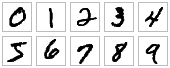

<class 'numpy.ndarray'> (60000, 28, 28)
2 (28, 28) uint8


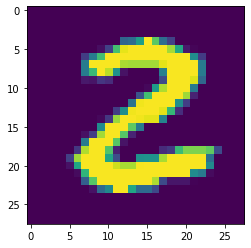

In [85]:
import matplotlib.pyplot as pyplot

(train_data, train_label), (test_data, test_label) = mnist.load_data()
print(type(train_data), train_data.shape)
i = 25
tmp = train_data[i]
print(train_label[i], tmp.shape, tmp.dtype)

pyplot.imshow(tmp)
pyplot.show()

In [86]:
# 数据获取
import numpy as np

class MNISTLoader():
    def __init__(self):
        mnist = tf.keras.datasets.mnist
        (self.train_data, self.train_label), (self.test_data, self.test_label) = mnist.load_data()
        # MNIST中的图像默认为uint8（0-255的数字）。以下代码将其归一化到0-1之间的浮点数，并在最后增加一维作为颜色通道
        self.train_data = np.expand_dims(self.train_data.astype(np.float32) / 255.0, axis=-1)      # [60000, 28, 28, 1]
        self.test_data = np.expand_dims(self.test_data.astype(np.float32) / 255.0, axis=-1)        # [10000, 28, 28, 1]
        self.train_label = self.train_label.astype(np.int32)    # [60000]
        self.test_label = self.test_label.astype(np.int32)      # [10000]
        self.num_train_data, self.num_test_data = self.train_data.shape[0], self.test_data.shape[0]

    def get_batch(self, batch_size):
        # 从数据集中随机取出batch_size个元素并返回
        index = np.random.randint(0, self.num_train_data, batch_size)
        return self.train_data[index, :], self.train_label[index]

### 模型构建
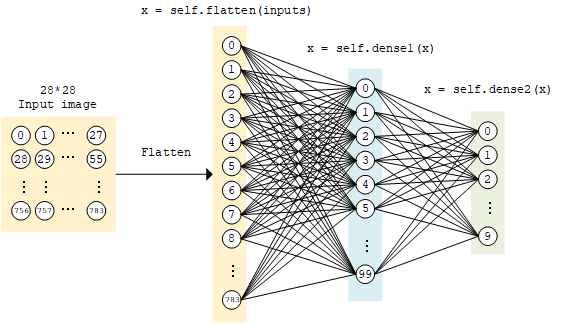

In [87]:
class MLP(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.flatten = tf.keras.layers.Flatten()    # Flatten层将除第一维（batch_size）以外的维度展平
        self.dense1 = tf.keras.layers.Dense(units=100, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(units=10)

    def call(self, inputs):         # [batch_size, 28, 28, 1]
        x = self.flatten(inputs)    # [batch_size, 784]
        x = self.dense1(x)          # [batch_size, 100]
        x = self.dense2(x)          # [batch_size, 10]
        output = tf.nn.softmax(x)
        return output

### 模型训练

In [83]:
# 定义超参数：
num_epochs=5
batch_size=50  # 每批次取50
learning_rate=0.01

# 实例化模型
model=MLP()
data_loader=MNISTLoader()
optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)


# 然后迭代进行以下步骤：
# 1从 DataLoader 中随机取一批训练数据；
num_batches=int(data_loader.num_train_data //batch_size*num_epochs)
for batch_index in range(num_batches):
    X,y = data_loader.get_batch(batch_size)


# 将这批数据送入模型，计算出模型的预测值；

# 将模型预测值与真实值进行比较，计算损失函数（loss）。这里使用 tf.keras.losses 中的交叉熵函数作为损失函数；

# 计算损失函数关于模型变量的导数；

# 将求出的导数值传入优化器，使用优化器的 apply_gradients 方法更新模型参数以最小化损失函数（优化器的详细使用方法见 前章 ）。

<module 'tensorflow.keras.datasets.mnist' from '/Users/dufy/anaconda3/lib/python3.7/site-packages/tensorflow/keras/datasets/mnist/__init__.py'>
<class 'numpy.ndarray'> (60000, 28, 28)
<class 'numpy.ndarray'> (60000, 28, 28, 1)
